With thanks to Lucky Pattanaik for supplying the majority of this code.
- Violin plot works in 3d-rdkit env. 
- For some reason, the second plot requires the original ts_gen environment. 
- Safer to stay in ts_gen environment here. TODO: post this environment, too.

In [1]:
from rdkit import Chem
from IPython.display import display, HTML
from rdkit.Chem import rdDepictor
import rdkit.Chem.Draw as Draw
from IPython.display import SVG, display, clear_output, HTML
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
from rdkit.Chem.rdmolops import GetAdjacencyMatrix, GetDistanceMatrix, Get3DDistanceMatrix
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# base_folder = r'../data/raw/' # normal
base_folder = 'Users/rmhavij/3d-reactions/data/raw/' # azure

train_r_file = base_folder + 'train_reactants.sdf'
train_ts_file = base_folder + 'train_ts.sdf'
train_p_file = base_folder + 'train_products.sdf'

test_r_file = base_folder + 'test_reactants.sdf'
test_ts_file = base_folder + 'test_ts.sdf'
test_p_file = base_folder + 'test_products.sdf'

train_r = Chem.SDMolSupplier(train_r_file, removeHs=False, sanitize=False)
train_r = [x for x in train_r]
train_ts = Chem.SDMolSupplier(train_ts_file, removeHs=False, sanitize=False)
train_ts = [x for x in train_ts]
train_p = Chem.SDMolSupplier(train_p_file, removeHs=False, sanitize=False)
train_p = [x for x in train_p]

test_r = Chem.SDMolSupplier(test_r_file, removeHs=False, sanitize=False)
test_r = [x for x in test_r]
test_ts = Chem.SDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [x for x in test_ts]
test_p = Chem.SDMolSupplier(test_p_file, removeHs=False, sanitize=False)
test_p = [x for x in test_p]


# weights: the weight matrices from ts_gen model
# atom_weights_file = 'mit_atom_importance_weights.npy' # normal
atom_weights_file = 'Users/rmhavij/3d-reactions/notebooks/data/mit_atom_importance_weights.npy' # azure
atom_weights = np.load(atom_weights_file)

# each column (i.e. raw_weights[i]) is length 21 for max num_atoms
# raw_atom_weights_file = 'mit_masked_raw_weights.npy' # normal
raw_atom_weights_file = 'Users/rmhavij/3d-reactions/notebooks/data/mit_masked_raw_weights.npy' # azure
raw_weights = np.load(raw_atom_weights_file)

In [5]:
train_rxns = list(zip(train_r, train_ts, train_p))
test_rxns = list(zip(test_r, test_ts, test_p))

In [6]:
# distances between reactants and products (no transition states here)
rpDs = []
rp3Ds = []
bws = []

for i in range(len(test_r)):

    # topological distance matrix average
    rpD = (GetDistanceMatrix(test_r[i]) + GetDistanceMatrix(test_p[i])) / 2
    rpDs.extend(list(np.ravel(rpD))) # ravel gives contiguous flattened array

    # 3D distance matrix average
    rp3D = (Get3DDistanceMatrix(test_r[i]) + Get3DDistanceMatrix(test_p[i]))/2
    rp3Ds.extend(list(np.ravel(rp3D)))
    
    mol = test_ts[i]
    n_atoms = mol.GetNumAtoms()
    w = raw_weights[i][raw_weights[i] != 0].reshape(n_atoms,n_atoms)
    bond_weights = w / np.max(w) # normalise by max weight
    bws.extend(list(np.ravel(bond_weights)))

In [7]:
def make_violinplot(data, x, y, counts=False, data2=None,
                    connect_medians=False, log=False, trim=False, box_only=False, showfliers=True,
                    xlabel=None, ylabel=None, title=None, counts_label=None, figsize=(7, 7), path=None):
    
    fig = plt.figure(figsize=figsize)
    
    with sns.axes_style('white', rc={'axes.edgecolor': '.3', 'ytick.left': True}):
        if counts:
            gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[2, 1])
            ax = plt.subplot(gs[0])
        else:
            ax = fig.gca()

    num_plots = x.nunique()

    # blue colour palette
    palette = sns.cubehelix_palette(8, start=5.8, rot=.1)
    
    box_width = 0.6
    if box_only:
        data_dict = data.groupby(x.name)[y.name].apply(list).to_dict()
        sorted_keys = sorted(data_dict.keys())
        xdata = [data_dict.get(k) for k in sorted_keys]
        positions = list(range(len(xdata)))
        mean_marker_settings = dict(color='w', marker='*', markersize=7, markeredgewidth=1.5, markeredgecolor='k')
        bp = ax.boxplot(xdata, positions=positions, widths=box_width, showfliers=showfliers, showmeans=True, meanprops=mean_marker_settings, patch_artist=True)
        linewidths = [1.5 , 1.5, 1.5, 1.5, 1.5]
        for i,element in enumerate(['boxes', 'whiskers', 'means', 'medians', 'caps']):
            plt.setp(bp[element], color='k', linewidth=linewidths[i])
        plt.setp(bp['fliers'], markeredgecolor='red', marker='+', markeredgewidth=1, markersize=4, alpha=0.3)
        for patch, color in zip(bp['boxes'], palette):
            patch.set(facecolor=color)
        leg = [matplotlib.lines.Line2D([0], [0], label='Mean', **mean_marker_settings)]
        ax.legend(handles=leg, fontsize=22)
    else:
        ax = sns.violinplot(x=x, y=y, data=data, ax=ax, cut=0 if trim else 2, palette=palette)
    
    ax.tick_params(axis='y', which='both', direction='out', labelsize=22)
    ax.tick_params(axis='x', which='both', direction='out', labelsize=0)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(True)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(True)  
    
    if connect_medians:
        medians = data.groupby(x.name)[y.name].median()
        x_pos = ax.get_xticks()
        ax.plot(x_pos, medians, color='dimgray', linestyle='--', linewidth=1, zorder=10)

    if counts:
        ax.set_xlabel(None)
    elif xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=22)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=22, labelpad=38)
    if title is not None:
        ax.set_title(title, fontsize=22)
        
    if counts:
        with sns.axes_style('white', rc={'axes.edgecolor': '.3', 'ytick.left': True}):
            ax2 = plt.subplot(gs[1], sharex=ax)

        data2 = data if data2 is None else data2
        width_bak = sns.categorical._BarPlotter.width
        sns.categorical._BarPlotter.width = box_width  # This changes a class variable
        ax2 = sns.countplot(x=x, data=data2, log=log, ax=ax2, linewidth=1.5, edgecolor='k', palette=palette)
        sns.categorical._BarPlotter.width = width_bak

        ax2.tick_params(which='both', direction='out', labelsize=22)
        if xlabel is not None:
            ax2.set_xlabel(xlabel, fontsize=22, labelpad=5)
        if counts_label is not None:
            #ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
            ax2.set_ylabel(counts_label, fontsize=22, labelpad=5)
            ax2.set_yticks([0, 10000, 20000, 30000])
    
    ax2.spines["top"].set_visible(False)    
    ax2.spines["bottom"].set_visible(True)    
    ax2.spines["right"].set_visible(False)    
    ax2.spines["left"].set_visible(True)  
    fig.subplots_adjust(hspace=0.02)

    if path is not None:
        fig.savefig(path, bbox_inches='tight')

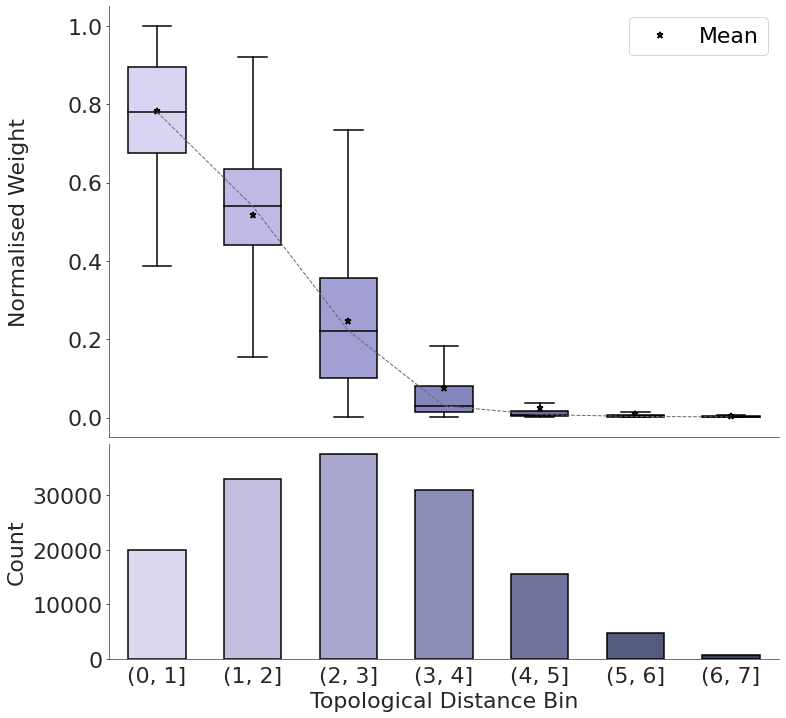

In [8]:
# topological distance bins
data = pd.DataFrame({'top_distance': rpDs, 'bond_weights': bws})
data['binned'] = pd.cut(x=data['top_distance'], bins=range(8))
make_violinplot(x=data['binned'], y=data['bond_weights'], data=data, counts=True, box_only=True,
                showfliers=False, xlabel='Topological Distance Bin', ylabel='Normalised Weight', 
                counts_label='Count', connect_medians=True,
                figsize=(12,12), path=None)

### Model importance weighting
- Weight matrices tell us which bonds are important when reconstructing TS. 
- Extract weights from model and normalise by maximum weight per molecule. Weights are binned based on topological distance between R and P (i.e. average number of bonds separating two atoms to which the weight corresponds).
- Trend shows that model prioritises preserving distances of topologically nearby atoms when reconstructing coordinates from the predicted distance matrix -> that's why model producing valid geometries.

#### My notes
- Could I do something similar but for {node/edge/path} features. Would better capture substructure in the molecule.
    - Figure out weights across substructures in the molecule e.g. not just bonds (i.e. 1D paths) between atoms but submolecules (i.e. 2D structures) between atoms.
    - Could you extend that to 3D paths, too?
    - Would this mean looking at substructure dynamics? e.g. how do higher order paths change? 

In [11]:
def get_scaled_drawer(mol):
    # draw all molecules in 2D with same proportions
    dpa = 50
    rdDepictor.Compute2DCoords(mol)
    conf = mol.GetConformer()
    xs = [conf.GetAtomPosition(i).x for i in range(mol.GetNumAtoms())]
    ys = [conf.GetAtomPosition(i).y for i in range(mol.GetNumAtoms())]
    point_min = Geometry.rdGeometry.Point2D()
    point_max = Geometry.rdGeometry.Point2D()
    point_min.x = min(xs) - 1
    point_min.y = min(ys) - 1
    point_max.x = max(xs) + 1
    point_max.y = max(ys) + 1
    w = int(dpa * (point_max.x - point_min.x))
    h = int(dpa * (point_max.y - point_min.y))
    drawer = rdMolDraw2D.MolDraw2DSVG(w, h)
    drawer.SetScale(w, h, point_min, point_max)
    return drawer

def draw(mol, scoreLabels=False, atomLabels=False, **kwargs):
    # draw the figures
    atomScores = kwargs.pop('atomScores', [])
    d2 = get_scaled_drawer(mol)
    dopts = d2.drawOptions()
    # what are score labels?
    if scoreLabels:
        for i, sco in enumerate(atomScores):
            if round(sco*100) >= 1:
                dopts.atomLabels[i] = '{}%'.format(int(round(sco*100)))
    elif atomLabels:
        for i in range(mol.GetNumAtoms()):
            dopts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)
    #dopts.highlightBonds=[]
    m2 = Draw.PrepareMolForDrawing(mol)
    d2.DrawMolecule(m2, **kwargs)
    d2.FinishDrawing()
    txt = d2.GetDrawingText()
    return txt

In [31]:
# making sure he was getting adj matrix in his original code
not_same = []
for i in range(len(test_p)):
    same = (GetAdjacencyMatrix(test_p[i]) == (Chem.GetDistanceMatrix(test_p[i]) == 1)*1).all()
    if not same:
        not_same.append(i)

21

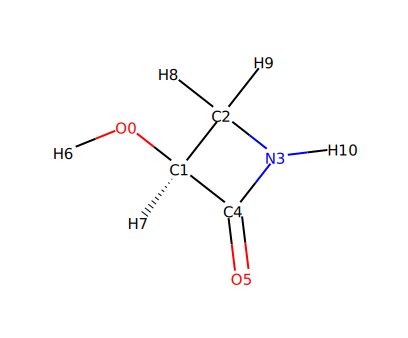

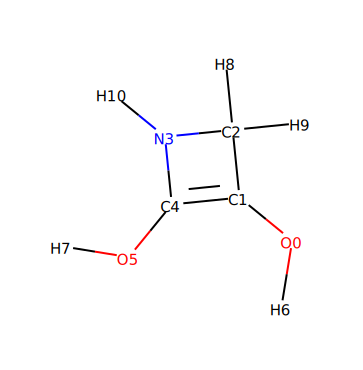

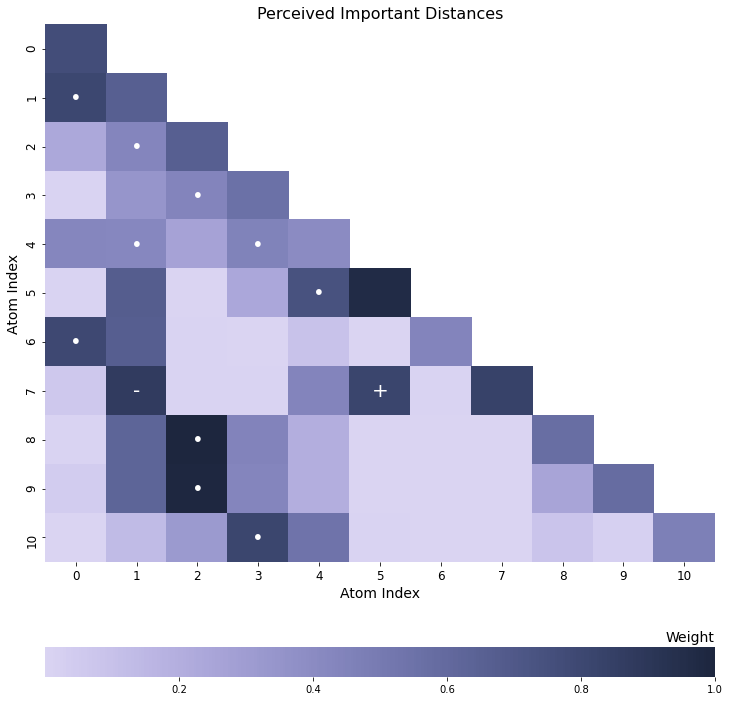

In [12]:
from __future__ import unicode_literals

def generate_importance_plot(i, save=False):

    # get adjacency matrix
    rD = GetAdjacencyMatrix(test_r[i])
    pD = GetAdjacencyMatrix(test_p[i])
    rpD = (rD+pD)/2
    #rpDs.append(rpD)

    # 3D distance matrix
    r3D = Get3DDistanceMatrix(test_r[i])
    p3D = Get3DDistanceMatrix(test_p[i])
    rp3D = (r3D+p3D)/2
    #rp3Ds.append(rp3D)

    mol = test_ts[i]
    n_atoms = mol.GetNumAtoms()
    w = raw_weights[i][raw_weights[i] != 0].reshape(n_atoms,n_atoms)
    bond_weights = w / np.max(w) # normalisenp.divide(w,max(np.max(w, axis=1)))  # normalize
    #bond_weight_matrices.append(bond_weights)
    
    # generate labels for plot
    labels = 2*(pD - rD) + (rD*pD)
    labels = np.array(labels, dtype=str)
    labels = np.where(labels=='2', '+', labels) 
    labels = np.where(labels=='-2', '-', labels)
    labels = np.where(labels=='0', '', labels) 
    # labels = np.where(labels=='1', '*', labels) 
    labels = np.where(labels=='1', u'\u2022', labels) 
    
    # draw reactant and product
    r_mol = test_r[i]
    r_drawing = draw(r_mol, atomLabels=True)
    display(SVG(r_drawing))
    p_mol = test_p[i]
    p_drawing = draw(p_mol, atomLabels=True)
    display(SVG(p_drawing))
    
    # plot importance
    grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
    cbar_kws={"orientation": "horizontal"}
    fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(12,12))
    mask = np.zeros_like(bond_weights, dtype=np.bool)
    mask[np.triu_indices_from(mask, k=1)] = True
    ax = sns.heatmap(bond_weights**2, ax=ax, cbar_ax=cbar_ax, mask=mask, cbar_kws=cbar_kws,
                     cmap=sns.cubehelix_palette(8, start=5.8, rot=.1, as_cmap=True), annot=labels, fmt="", annot_kws={"size": 20})
    ax.set_xlabel('Atom Index', fontsize=14)
    ax.set_ylabel('Atom Index', fontsize=14)
    ax.set_title('Perceived Important Distances', fontsize=16)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    cbar_ax.set_title('Weight', fontsize=14, loc='right')
    
    if save:
        ax.figure.savefig('/plot' + str(1) + '.png', dpi=2000, bbox_inches='tight')

generate_importance_plot(10, save=False)